# Importing libraries


In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load data


In [13]:
kickstarter_df = pd.read_csv("./data/Part2.Team8.kickstarter_data_full.csv", low_memory=False)


# Drop unnecessary columns


In [14]:
kickstarter_df.drop(columns=["index", "Unnamed: 0", "id"], inplace=True)

# Naive feature selection


## Remove features with more that 50% missing values


In [15]:
kickstarter_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20632 entries, 0 to 20631
Data columns (total 66 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   photo                        20632 non-null  object 
 1   name                         20632 non-null  object 
 2   blurb                        20626 non-null  object 
 3   goal                         20632 non-null  float64
 4   pledged                      20632 non-null  float64
 5   state                        20632 non-null  object 
 6   slug                         20632 non-null  object 
 7   disable_communication        20632 non-null  bool   
 8   country                      20632 non-null  object 
 9   currency                     20632 non-null  object 
 10  currency_symbol              20632 non-null  object 
 11  currency_trailing_code       20632 non-null  bool   
 12  deadline                     20632 non-null  object 
 13  state_changed_at

In [16]:
kickstarter_df.drop(
    columns=["friends", "is_starred", "is_backing", "permissions"], inplace=True
)


## Check features with zero variance


In [17]:
kickstarter_df.nunique()[kickstarter_df.nunique() == 1]

Series([], dtype: int64)

## Check rows with missing values


In [18]:
kickstarter_df.isnull().any(axis=1).sum()

1937

In [19]:
# check for features that have missing values
kickstarter_df.isnull().sum()[kickstarter_df.isnull().sum() > 0]


blurb                 6
location             45
category           1889
name_len              5
name_len_clean        5
blurb_len             5
blurb_len_clean       5
dtype: int64

In [20]:
kickstarter_df.drop(columns=["location"], inplace=True)


### handle missing values for blurb


In [21]:
kickstarter_df["blurb"].fillna("", inplace=True)


In [23]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

### handle missing values for category


In [25]:
catgory_dict = {
    name: i for i, name in enumerate(kickstarter_df["category"].unique().tolist())
}


def get_category_id(x):
    return np.nan if pd.isnull(x) else catgory_dict[x]


# transform all
kickstarter_df["category"] = kickstarter_df["category"].apply(get_category_id)
kickstarter_df["category"] = knn_imputer.fit_transform(
    kickstarter_df["category"].values.reshape(-1, 1)
)

# inverse transform category
kickstarter_df["category"] = kickstarter_df["category"].apply(
    lambda x: list(catgory_dict.keys())[int(x)]
)


In [26]:
kickstarter_df["category"].isnull().sum()


0

### handle missing values for name_len


In [27]:
kickstarter_df["name_len"] = knn_imputer.fit_transform(kickstarter_df[["name_len"]])


### handle missing values for name_len_clean


In [28]:
kickstarter_df["name_len_clean"] = knn_imputer.fit_transform(
    kickstarter_df[["name_len_clean"]]
)


### handle missing values for blurb_len


In [30]:
kickstarter_df["blurb_len"] = knn_imputer.fit_transform(kickstarter_df[["blurb_len"]])


### handle missing values for name_len_clean


In [31]:
kickstarter_df["blurb_len_clean"] = knn_imputer.fit_transform(
    kickstarter_df[["blurb_len_clean"]]
)


In [32]:
kickstarter_df[
    ["blurb_len_clean", "blurb_len", "name_len", "name_len_clean", "category"]
].isnull().sum()


blurb_len_clean    0
blurb_len          0
name_len           0
name_len_clean     0
category           0
dtype: int64

In [34]:
kickstarter_df.isnull().any(axis=1).sum()


0

# Statistical info


In [35]:
country_df = kickstarter_df["country"].value_counts().to_frame().reset_index()
# map the country codes to country names
country_df["country"] = country_df["country"].map(
    {
        "US": "United States",
        "GB": "United Kingdom",
        "CA": "Canada",
        "AU": "Australia",
        "DE": "Germany",
        "FR": "France",
        "NL": "Netherlands",
        "IT": "Italy",
        "ES": "Spain",
        "SE": "Sweden",
        "MX": "Mexico",
        "NZ": "New Zealand",
        "DK": "Denmark",
        "IE": "Ireland",
        "CH": "Switzerland",
        "NO": "Norway",
        "BE": "Belgium",
        "AT": "Austria",
        "HK": "Hong Kong",
        "SG": "Singapore",
        "LU": "Luxembourg",
        "JP": "Japan",
    }
)
country_norm = kickstarter_df.value_counts(["country"], normalize=True)
country_df["norm"] = country_norm.values
country_df["label"] = country_df.apply(
    lambda x: x["country"] if x["norm"] >= 0.03 else "other", axis=1
)
other_country_df = country_df[country_df["label"] == "other"]
country_df.drop(other_country_df.index, inplace=True)
group_other_country_df = other_country_df.groupby("label").sum().reset_index()
country_df = pd.concat([country_df, group_other_country_df], axis=0)
country_df.drop(columns=["country"], inplace=True)
import plotly.graph_objects as go

# Pie chart for the distribution of the country, category, currency, created_at_weekday
# under 3
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=country_df["label"],
        values=country_df["count"],
        name="country",
        text=country_df["label"],
    )
)
fig.update_layout(
    width=800,
    height=800,
    title_text="Distribution of the country",
    annotations=[
        dict(
            showarrow=False,
            x=0.5,
            y=0.5,
            text="",
            font_size=20,
            font_family="Arial",
        )
    ],
)

fig.show()


In [36]:
currency_df = kickstarter_df["currency"].value_counts().to_frame().reset_index()
currency_df["currency"] = currency_df["currency"].map(
    {
        "USD": "US Dollar",
        "GBP": "British Pound Sterling",
        "CAD": "Canadian Dollar",
        "AUD": "Australian Dollar",
        "EUR": "Euro",
        "SEK": "Swedish Krona",
        "NZD": "New Zealand Dollar",
        "DKK": "Danish Krone",
        "NOK": "Norwegian Krone",
        "CHF": "Swiss Franc",
        "MXN": "Mexican Peso",
        "HKD": "Hong Kong Dollar",
        "SGD": "Singapore Dollar",
        "JPY": "Japanese Yen",
    }
)
currency_norm = kickstarter_df.value_counts(["currency"], normalize=True)
currency_df["norm"] = currency_norm.values
currency_df["label"] = currency_df.apply(
    lambda x: x["currency"] if x["norm"] >= 0.03 else "other", axis=1
)
other_currency_df = currency_df[currency_df["label"] == "other"]
currency_df.drop(other_currency_df.index, inplace=True)
group_other_currency_df = other_currency_df.groupby("label").sum().reset_index()
currency_df = pd.concat([currency_df, group_other_currency_df], axis=0)
currency_df.drop(columns=["currency"], inplace=True)
import plotly.graph_objects as go

# Pie chart for the distribution of the country, category, currency, created_at_weekday
# under 3
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=currency_df["label"],
        values=currency_df["count"],
        name="currency",
        text=currency_df["label"],
    )
)
fig.update_layout(
    width=800,
    height=800,
    title_text="Distribution of the currency",
    annotations=[
        dict(
            showarrow=False,
            x=0.5,
            y=0.5,
            text="",
            font_size=20,
            font_family="Arial",
        )
    ],
)
fig.show()


In [37]:
category_df = kickstarter_df["category"].value_counts().to_frame().reset_index()
category_norm = kickstarter_df.value_counts(["category"], normalize=True)
category_df["norm"] = category_norm.values
category_df["label"] = category_df.apply(
    lambda x: x["category"] if x["norm"] >= 0.03 else "other", axis=1
)
other_category_df = category_df[category_df["label"] == "other"]
category_df.drop(other_category_df.index, inplace=True)
group_other_category_df = other_category_df.groupby("label").sum().reset_index()
category_df = pd.concat([category_df, group_other_category_df], axis=0)
category_df.drop(columns=["category"], inplace=True)
import plotly.graph_objects as go

# Pie chart for the distribution of the country, category, currency, created_at_weekday
# under 3
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=category_df["label"],
        values=category_df["count"],
        name="category",
        text=category_df["label"],
    )
)
fig.update_layout(
    width=800,
    height=800,
    title_text="Distribution of the category",
    annotations=[
        dict(
            showarrow=False,
            x=0.5,
            y=0.5,
            text="",
            font_size=20,
            font_family="Arial",
        )
    ],
)
fig.show()


In [15]:
weekday_df = (
    kickstarter_df["created_at_weekday"].value_counts().to_frame().reset_index()
)
weekday_norm = kickstarter_df.value_counts(["created_at_weekday"], normalize=True)
weekday_df["norm"] = weekday_norm.values
weekday_df["label"] = weekday_df.apply(
    lambda x: x["created_at_weekday"] if x["norm"] >= 0.03 else "other", axis=1
)
other_weekday_df = weekday_df[weekday_df["label"] == "other"]
weekday_df.drop(other_weekday_df.index, inplace=True)
group_other_weekday_df = other_weekday_df.groupby("label").sum().reset_index()
weekday_df = pd.concat([weekday_df, group_other_weekday_df], axis=0)
weekday_df.drop(columns=["created_at_weekday"], inplace=True)
import plotly.graph_objects as go

# Pie chart for the distribution of the country, category, currency, created_at_weekday
# under 3
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=weekday_df["label"],
        values=weekday_df["count"],
        name="weekday",
        text=weekday_df["label"],
    )
)
fig.update_layout(
    width=800,
    height=800,
    title_text="Distribution of the weekday",
    annotations=[
        dict(
            showarrow=False,
            x=0.5,
            y=0.5,
            text="",
            font_size=20,
            font_family="Arial",
        )
    ],
)
fig.show()


In [38]:
kickstarter_df.describe().astype("Float64")

,goal,pledged,backers_count,static_usd_rate,usd_pledged,name_len,name_len_clean,blurb_len,blurb_len_clean,deadline_month,...,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,SuccessfulBool,USorGB,TOPCOUNTRY,LaunchedTuesday,DeadlineWeekend
count,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0,...,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0,20632.0
mean,94104.965285,21392.675739,183.675843,1.039363,20915.907911,5.940806,5.292578,18.991177,13.081204,6.707784,...,2014.752084,12.417168,49.577598,34.716896,31.169397,0.291683,0.806466,0.816208,0.225136,0.292022
std,1335511.390003,120497.251802,1222.012658,0.230419,115471.73309,2.825776,2.417875,4.631809,3.283149,3.41142,...,1.261752,5.574409,111.094601,11.873143,14.279705,0.454548,0.395078,0.387324,0.417682,0.454703
min,1.0,0.0,0.0,0.045641,0.0,1.0,1.0,1.0,1.0,1.0,...,2009.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,4000.0,25.0,2.0,1.0,25.0,4.0,3.0,17.0,11.0,4.0,...,2014.0,9.0,3.0,30.0,28.0,0.0,1.0,1.0,0.0,0.0
50%,14000.0,695.0,12.0,1.0,716.301193,6.0,5.0,20.0,13.0,7.0,...,2015.0,12.0,14.0,30.0,30.0,0.0,1.0,1.0,0.0,0.0
75%,50000.0,5954.25,63.0,1.0,6004.628177,8.0,7.0,22.0,15.0,10.0,...,2016.0,16.0,45.0,40.0,35.0,1.0,1.0,1.0,0.0,1.0
max,100000000.0,6225354.98,105857.0,1.715913,6225354.98,16.0,14.0,35.0,30.0,12.0,...,2017.0,23.0,1754.0,91.0,91.0,1.0,1.0,1.0,1.0,1.0


# Check the cases of the "SuccessfulBool" (dependent) variable


In [40]:
kickstarter_df["SuccessfulBool"].value_counts()


SuccessfulBool
0    14614
1     6018
Name: count, dtype: int64

# Hypothesis 5: The category of the project is related to the success of the project.

# Hypothesis 6: The name and the blurb of the project will affect the success of the project

In [42]:
h5_h6_df = kickstarter_df[["blurb", "name", "category", "SuccessfulBool"]]


### make a new column with the concatenation of blurb and name and category for vectorization


In [43]:
h5_h6_df["concatenated_string"] = (
    h5_h6_df["blurb"] + " " + h5_h6_df["name"] + " " + h5_h6_df["category"]
)


### drop columns after concatenation


In [44]:
h5_h6_df.drop(columns=["blurb", "name", "category"], inplace=True)


# Split into X and y


In [45]:
X = h5_h6_df.drop(columns="SuccessfulBool")
y = h5_h6_df["SuccessfulBool"]


## Logistic Regression


In [46]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

blurb_train, blurb_test, y_train, y_test = train_test_split(
    X["concatenated_string"], y, test_size=0.2, random_state=42
)

vectorizer = CountVectorizer()

vectorizer.fit(blurb_train)

X_train = vectorizer.transform(blurb_train)

X_test = vectorizer.transform(blurb_test)

classifier = LogisticRegression()

classifier.fit(X_train, y_train)

LogisticRegression()

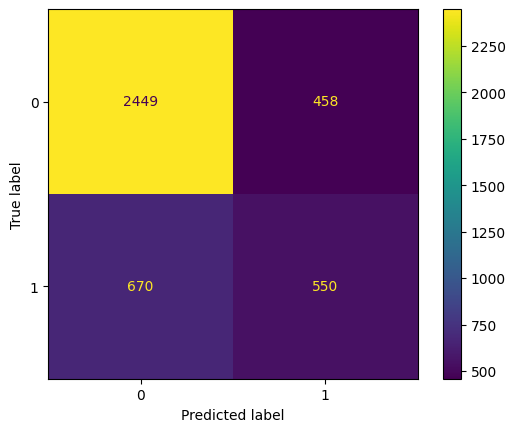

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, classifier.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()


In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, classifier.predict(X_test)))


              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2907
           1       0.55      0.45      0.49      1220

    accuracy                           0.73      4127
   macro avg       0.67      0.65      0.65      4127
weighted avg       0.71      0.73      0.72      4127



## Multinomial Naive Bayes


In [51]:
from sklearn.naive_bayes import MultinomialNB

blurb_train, blurb_test, y_train, y_test = train_test_split(
    X["concatenated_string"], y, test_size=0.2, random_state=42
)

vectorizer = CountVectorizer()

vectorizer.fit(blurb_train)

X_train = vectorizer.transform(blurb_train)

X_test = vectorizer.transform(blurb_test)

classifier = MultinomialNB()

classifier.fit(X_train, y_train)


MultinomialNB()

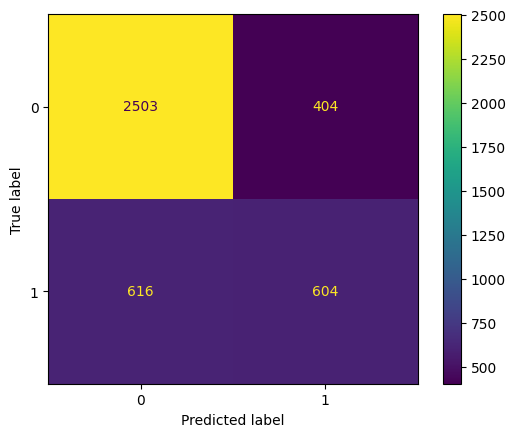

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, classifier.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()


In [53]:
print(classification_report(y_test, classifier.predict(X_test)))


              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2907
           1       0.60      0.50      0.54      1220

    accuracy                           0.75      4127
   macro avg       0.70      0.68      0.69      4127
weighted avg       0.74      0.75      0.75      4127



## Neural Network


Epoch 1/6
516/516 [==============================] - 1s 2ms/step - loss: 0.5980 - accuracy: 0.7093 - val_loss: 0.5876 - val_accuracy: 0.7044
Epoch 2/6
516/516 [==============================] - 1s 2ms/step - loss: 0.5402 - accuracy: 0.7248 - val_loss: 0.5197 - val_accuracy: 0.7303
Epoch 3/6
516/516 [==============================] - 1s 2ms/step - loss: 0.4854 - accuracy: 0.7607 - val_loss: 0.5054 - val_accuracy: 0.7473
Epoch 4/6
516/516 [==============================] - 1s 2ms/step - loss: 0.4700 - accuracy: 0.7695 - val_loss: 0.5096 - val_accuracy: 0.7434
Epoch 5/6
516/516 [==============================] - 1s 2ms/step - loss: 0.4622 - accuracy: 0.7735 - val_loss: 0.5027 - val_accuracy: 0.7509
Epoch 6/6
516/516 [==============================] - 1s 2ms/step - loss: 0.4551 - accuracy: 0.7783 - val_loss: 0.5033 - val_accuracy: 0.7499


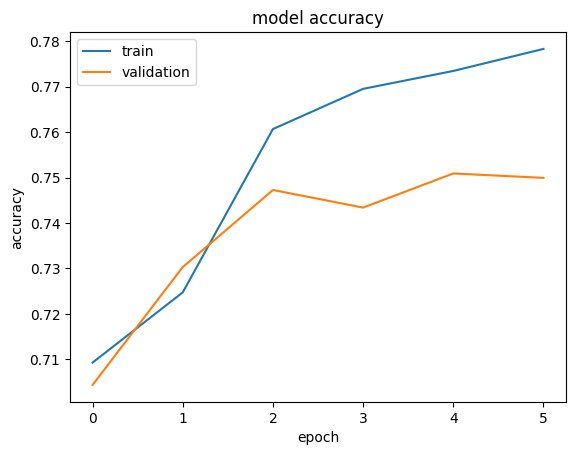

In [57]:
from sklearn.model_selection import train_test_split

# set seed for reproducibility
tf.random.set_seed(42)

# text classification
import tensorflow as tf

blurb_train, blurb_test, y_train, y_test = train_test_split(
    X["concatenated_string"], y, test_size=0.2, random_state=42
)

# Create a tokenizer to preprocess our text descriptions
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(blurb_train)

# Create training and validation sets using an 80-20 split
training_sequences = tokenizer.texts_to_sequences(blurb_train)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(
    training_sequences, maxlen=100, padding="post", truncating="post"
)

validation_sequences = tokenizer.texts_to_sequences(blurb_test)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(
    validation_sequences, maxlen=100, padding="post", truncating="post"
)

# Create the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(1000, 16, input_length=100),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history = model.fit(
    training_padded, y_train, epochs=6, validation_data=(validation_padded, y_test)
)

# Plot the accuracy and loss curves
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()
